In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime, random
import numpy as np; np.random.seed(13)
import matplotlib.pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate as concat
from keras import backend as K
from keras.optimizers import Adam
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import keras
import h5py
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, Normalizer, StandardScaler
import math
#from sklearn.externals import joblib
import joblib
from keras.layers import BatchNormalization
from keras.callbacks import CSVLogger
from scipy.stats import norm
#import logging
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
%matplotlib inline
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
#required for efficient GPU use
import tensorflow as tf
from keras.backend import tensorflow_backend
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

In [3]:
# load  preprocessed dataset
data=pd.read_csv("./data.csv")


In [4]:
data.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3,2,0,12,0,6,6,6.0,0.0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,109,1,1,6,6,6,6,6.0,0.0,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,52,1,1,6,6,6,6,6.0,0.0,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,34,1,1,6,6,6,6,6.0,0.0,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,3,2,0,12,0,6,6,6.0,0.0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0


In [5]:
data['Label'].value_counts()

0    667378
1    379737
Name: Label, dtype: int64

In [6]:
normal_mask = data['Label']== 0
attack_mask = data['Label']!= 0

data_normal = data[normal_mask]
data_attack = data[attack_mask]

print(f"Normal count: {len(data_normal)}")
print(f"Attack count: {len(data_attack)}")

Normal count: 667378
Attack count: 379737


In [7]:
# convert dataframes to numpy arrays
x_normal = data_normal.values
x_attack = data_attack.values
print(x_normal.shape, x_attack.shape)

(667378, 77) (379737, 77)


In [8]:
#train-test split for data_norm
from sklearn.model_selection import train_test_split
x_normal_train, x_normal_test = train_test_split(x_normal, test_size=0.25, random_state=40)
print(x_normal_train.shape, x_normal_test.shape)
x_normal_train_woLabel = x_normal_train[:,0:76]
x_normal_test_woLabel = x_normal_test[:,0:76]
x_normal_woLabel=x_normal[:,0:76]
x_attack_woLabel=x_attack[:,0:76]

(500533, 77) (166845, 77)


In [9]:
print(x_normal_train_woLabel.shape,x_normal_test_woLabel.shape)
print(x_normal_woLabel.shape,x_attack_woLabel.shape)

(500533, 76) (166845, 76)
(667378, 76) (379737, 76)


In [10]:
y_normal_train = x_normal_train[:,76]
y_normal_test = x_normal_test[:,76]

In [11]:
print(y_normal_train.shape)
print(y_normal_train)
print(y_normal_test.shape)
y_normal_test

(500533,)
[0. 0. 0. ... 0. 0. 0.]
(166845,)


array([0., 0., 0., ..., 0., 0., 0.])

In [12]:
###Scaling the data before feeding into the model

import joblib
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
x_normal_train_woLabel= scaler.fit_transform(x_normal_train_woLabel)
x_normal_test_woLabel= scaler.transform(x_normal_test_woLabel)
print(x_normal_train_woLabel[0], x_normal_test_woLabel[0])

#normalize other normal and attack testing data using the same scaler used above 
x_normal_woLabel= scaler.transform(x_normal_woLabel)
x_attack_woLabel= scaler.transform(x_attack_woLabel)



[9.30383434e-04 1.37201187e-05 6.86671702e-06 9.00683373e-03
 4.05615331e-08 4.67163578e-01 0.00000000e+00 6.24951843e-01
 8.13475813e-01 1.02406554e-03 2.79589935e-03 3.53736149e-03
 3.49427728e-03 5.02856890e-05 1.79137631e-05 1.88070019e-04
 5.15556521e-04 8.33825000e-04 3.79017200e-07 9.30383333e-04
 3.10127778e-04 6.48285628e-04 8.33825000e-04 3.75000000e-07
 1.70000000e-06 1.70000000e-06 0.00000000e+00 1.70000000e-06
 1.70000000e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.23901098e-05 6.86670288e-06 1.19425088e-05
 8.95688157e-06 0.00000000e+00 4.67163578e-01 6.76302932e-01
 9.25809417e-01 8.57142857e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.26013391e-01
 6.24951843e-01 3.53736149e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.37201187e-05 9.00683373e-03 6.86671702e-06 4.05615331e-08
 1.25001907e-01 3.906309

In [13]:
#display the size of test and train sets
print(f"Normal train count: {len(x_normal_train_woLabel)}")
print(f"Normal test count: {len(x_normal_test_woLabel)}")

Normal train count: 500533
Normal test count: 166845


In [15]:
x_normal_woLabel.shape[1]

76

In [16]:
model = Sequential()
model.add(Dense(76, input_dim=x_normal_woLabel.shape[1], activation='relu'))
model.add(Dense(3, activation='relu')) # size to compress to
model.add(Dense(32, activation='relu'))
model.add(Dense(x_normal_woLabel.shape[1])) # Multiple output neurons
model.summary()


W0713 21:12:36.157370 17340 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 21:12:36.159375 17340 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 21:12:36.164374 17340 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 76)                5852      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 231       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 76)                2508      
Total params: 8,719
Trainable params: 8,719
Non-trainable params: 0
_________________________________________________________________


In [18]:
##HYPERPARAMETERS
batch_size = 89
optim = Adam(lr=0.001)

In [19]:
model.compile(loss='mean_squared_error', optimizer=optim)
from time import time
t0 = time()
history=model.fit(x_normal_train_woLabel,x_normal_train_woLabel,validation_split=0.1,verbose=2,epochs=50,batch_size=batch_size, shuffle=True,callbacks = [EarlyStopping(patience = 5)]) #Number of epochs with no improvement after which training will be stopped

tf = time() - t0
print ("AE model trained in {} seconds".format(round(tf, 3)))
                     

W0713 21:13:50.689415 17340 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0713 21:13:50.850044 17340 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0713 21:13:51.010050 17340 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 450479 samples, validate on 50054 samples
Epoch 1/50
 - 19s - loss: 0.0017 - val_loss: 8.4330e-04
Epoch 2/50
 - 18s - loss: 7.8330e-04 - val_loss: 7.3653e-04
Epoch 3/50
 - 18s - loss: 7.1276e-04 - val_loss: 6.8599e-04
Epoch 4/50
 - 18s - loss: 6.6775e-04 - val_loss: 6.4641e-04
Epoch 5/50
 - 18s - loss: 6.1557e-04 - val_loss: 5.9313e-04
Epoch 6/50
 - 19s - loss: 5.8347e-04 - val_loss: 5.7589e-04
Epoch 7/50
 - 18s - loss: 5.6653e-04 - val_loss: 5.6196e-04
Epoch 8/50
 - 19s - loss: 5.5414e-04 - val_loss: 5.4239e-04
Epoch 9/50
 - 18s - loss: 5.4325e-04 - val_loss: 5.3420e-04
Epoch 10/50
 - 18s - loss: 5.3251e-04 - val_loss: 5.1597e-04
Epoch 11/50
 - 18s - loss: 5.2290e-04 - val_loss: 5.0499e-04
Epoch 12/50
 - 18s - loss: 5.1262e-04 - val_loss: 5.2134e-04
Epoch 13/50
 - 18s - loss: 5.0384e-04 - val_loss: 5.0557e-04
Epoch 14/50
 - 18s - loss: 4.9447e-04 - val_loss: 4.8415e-04
Epoch 15/50
 - 18s - loss: 4.8582e-04 - val_loss: 4.7854e-04
Epoch 16/50
 - 18s - loss: 4.7730e-04 - val_los

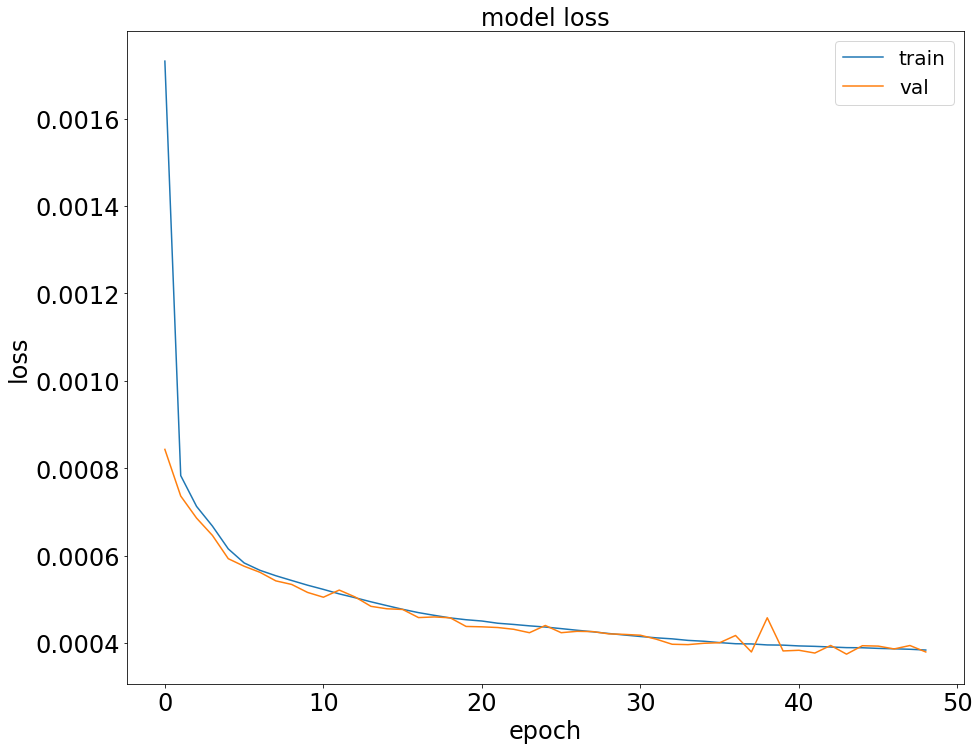

In [27]:
# # loss plot
import matplotlib as mpl

mpl.rcParams['font.size'] = 24
plt.rcParams["figure.figsize"] = (15,12)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss',fontsize = 24)
plt.ylabel('loss',fontsize = 24)
plt.xlabel('epoch',fontsize = 24)
plt.legend(['train', 'val'], loc='upper right',fontsize = 20)
#plt.savefig("VanillaAEloss.png", dpi=200)
plt.show()


(166845, 76)


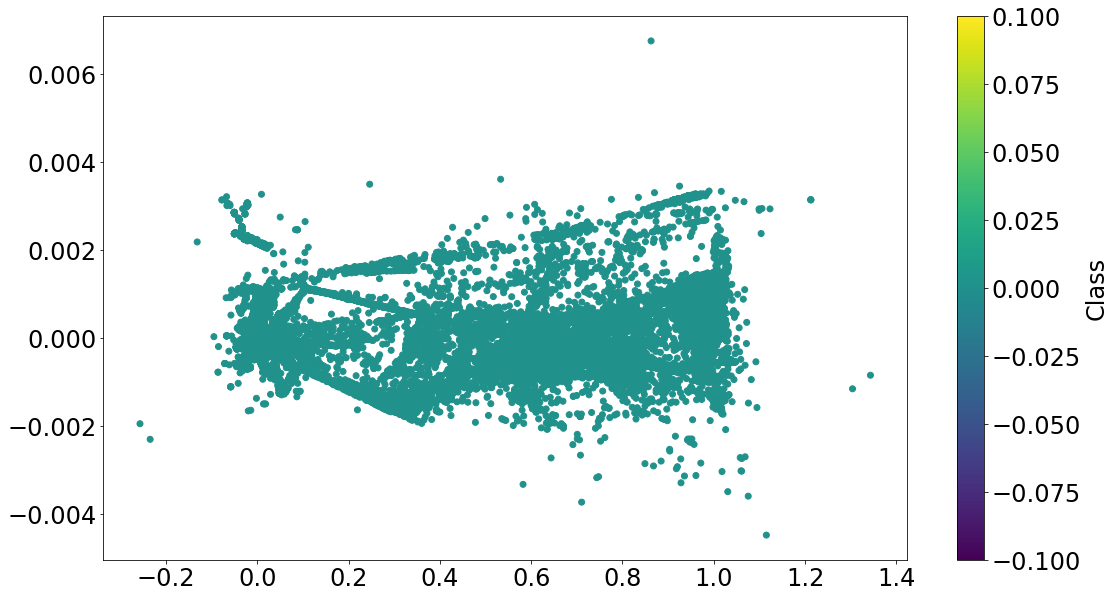

In [28]:
# Plot of the dataset classes in the latent space using the encoder for test/validation data
mpl.rcParams['font.size'] = 24
plt.rcParams["figure.figsize"] = (18,10)
x_normal_test_encoded = model.predict(x_normal_test_woLabel, batch_size=batch_size)
print(x_normal_test_encoded.shape)
plt.scatter(x_normal_test_encoded[:, 0], x_normal_test_encoded[:, 1], c = y_normal_test)
plt.colorbar(label='Class')
#plt.savefig("VanillaAEscatterplot.png", dpi=100)
plt.show()

In [39]:
# save model and architecture to single file
model.save("VanillaAEmodel.h5")

In [ ]:
#Detecting an Anomaly
#The first two scores show the in-sample and out of sample RMSE errors. 
#Both of these two scores are relatively low because they resulted from normal data.
#The much higher error occurred from the abnormal data. 
#The autoencoder is not as capable of encoding data that represents an attack. This higher error indicates an anomaly.

In [25]:
####make the predictions on different datasets
pred = model.predict(x_normal_test_woLabel)
score1 = np.sqrt(metrics.mean_squared_error(pred,x_normal_test_woLabel))
pred1 = model.predict(x_normal_woLabel)
score2 = np.sqrt(metrics.mean_squared_error(pred1,x_normal_woLabel))
pred2 = model.predict(x_attack_woLabel)
score3 = np.sqrt(metrics.mean_squared_error(pred2,x_attack_woLabel))
print(f"Out of Sample Normal Score (RMSE): {score1}")
print(f"Insample Normal Score (RMSE): {score2}")
print(f"Attack Underway Score (RMSE): {score3}")

Out of Sample Normal Score (RMSE): 0.01954391250047026
Insample Normal Score (RMSE): 0.019558733641947934
Attack Underway Score (RMSE): 0.1543810695802893


In [ ]:
#######Analyze the predictions############

In [45]:
###convert y_normal_test numpy format to dataframe format
y_normal_test_df = pd.DataFrame(data=y_normal_test,columns=['Label'])
y_normal_test_df.head()

,Label
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [47]:
###Out of Sample Normal test data 
mse1 = np.mean(np.power(x_normal_test_woLabel- pred, 2), axis=1)
data_error = pd.DataFrame({'reconstruction_error': mse1, 'Label': y_normal_test}, index=y_normal_test_df.index)
data_error.describe()

,reconstruction_error,Label
count,166845.000000,166845.0
mean,0.000382,0.0
std,0.001599,0.0
min,0.000017,0.0
25%,0.000035,0.0
50%,0.000076,0.0
75%,0.000189,0.0
max,0.152050,0.0


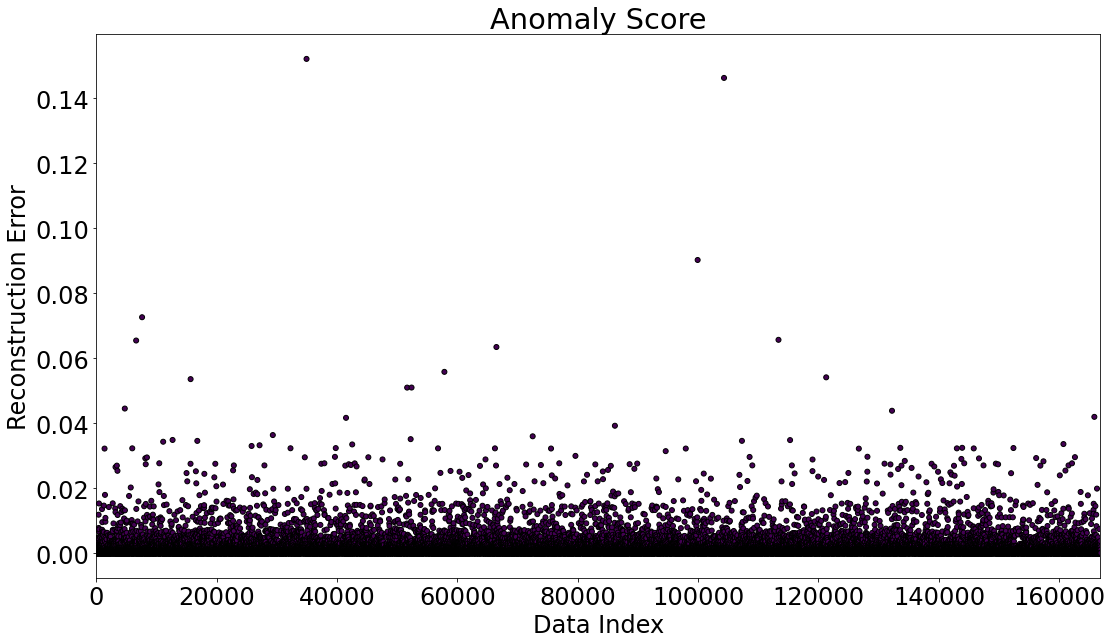

In [66]:
mpl.rcParams['font.size'] = 24
plt.rcParams["figure.figsize"] = (18,10)
#plt.figure(figsize=(16,8))
plt.scatter(data_error.index, data_error['reconstruction_error'], c=data_error['Label'], edgecolor='black', s=25)
plt.xlabel('Data Index', fontsize = 24)
plt.ylabel('Reconstruction Error', fontsize = 24)
plt.xlim((-10,166845))
plt.title("Anomaly Score")
#plt.savefig("Outliernormaloutsample.png", dpi=100)
plt.show()

In [53]:
###convert y_attack numpy format to dataframe format
y_attack = x_attack[:,76]
y_attack_df = pd.DataFrame(data=y_attack,columns=['Label'])
y_attack_df.head()

,Label
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [54]:
###Attack underway test data score
mse2 = np.mean(np.power(x_attack_woLabel- pred2, 2), axis=1)
data_error1 = pd.DataFrame({'reconstruction_error': mse2, 'Label': y_attack}, index=y_attack_df.index)
data_error1.describe()

,reconstruction_error,Label
count,379737.000000,379737.0
mean,0.023834,1.0
std,0.026807,0.0
min,0.000023,1.0
25%,0.000291,1.0
50%,0.009725,1.0
75%,0.042925,1.0
max,0.251001,1.0


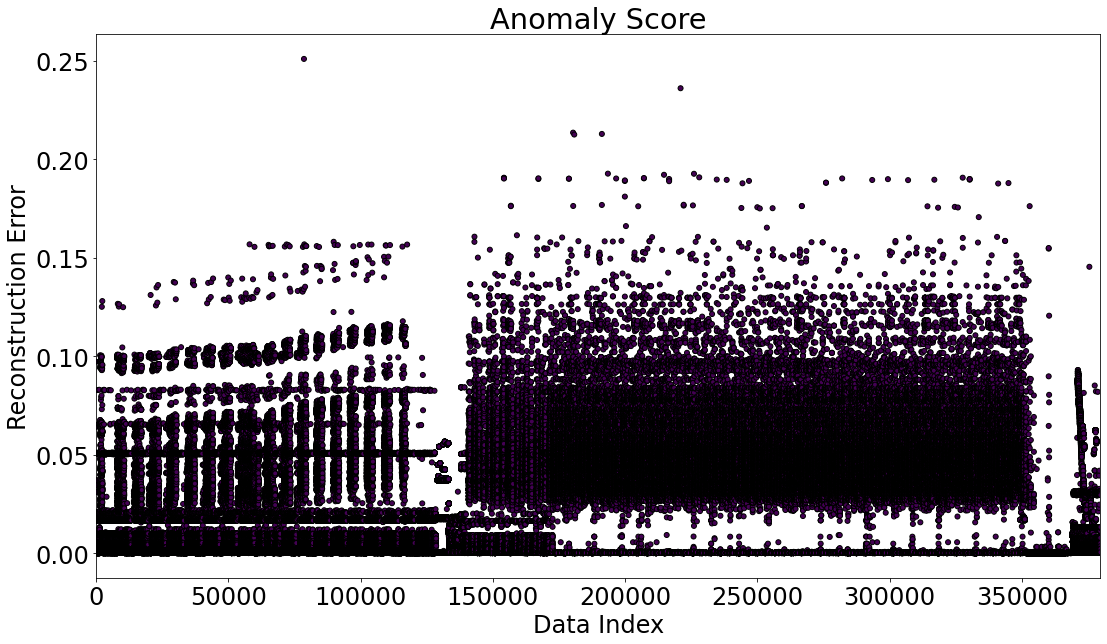

In [67]:
mpl.rcParams['font.size'] = 24
plt.rcParams["figure.figsize"] = (18,10)
plt.scatter(data_error1.index, data_error1['reconstruction_error'], c=data_error1['Label'], edgecolor='black', s=25)
plt.xlabel('Data Index', fontsize = 24)
plt.ylabel('Reconstruction Error', fontsize = 24)
plt.xlim((-10,379737))
plt.title("Anomaly Score")
plt.show()

In [56]:
###convert y_normal numpy format to dataframe format
y_normal = x_normal[:,76]
y_normal_df = pd.DataFrame(data=y_normal,columns=['Label'])
y_normal_df.head()

,Label
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [57]:
###InSample Normal data 

mse3 = np.mean(np.power(x_normal_woLabel- pred1, 2), axis=1)
data_error2 = pd.DataFrame({'reconstruction_error': mse3, 'Label': y_normal}, index=y_normal_df.index)
data_error2.describe()

,reconstruction_error,Label
count,667378.000000,667378.0
mean,0.000383,0.0
std,0.001659,0.0
min,0.000017,0.0
25%,0.000035,0.0
50%,0.000076,0.0
75%,0.000189,0.0
max,0.175852,0.0


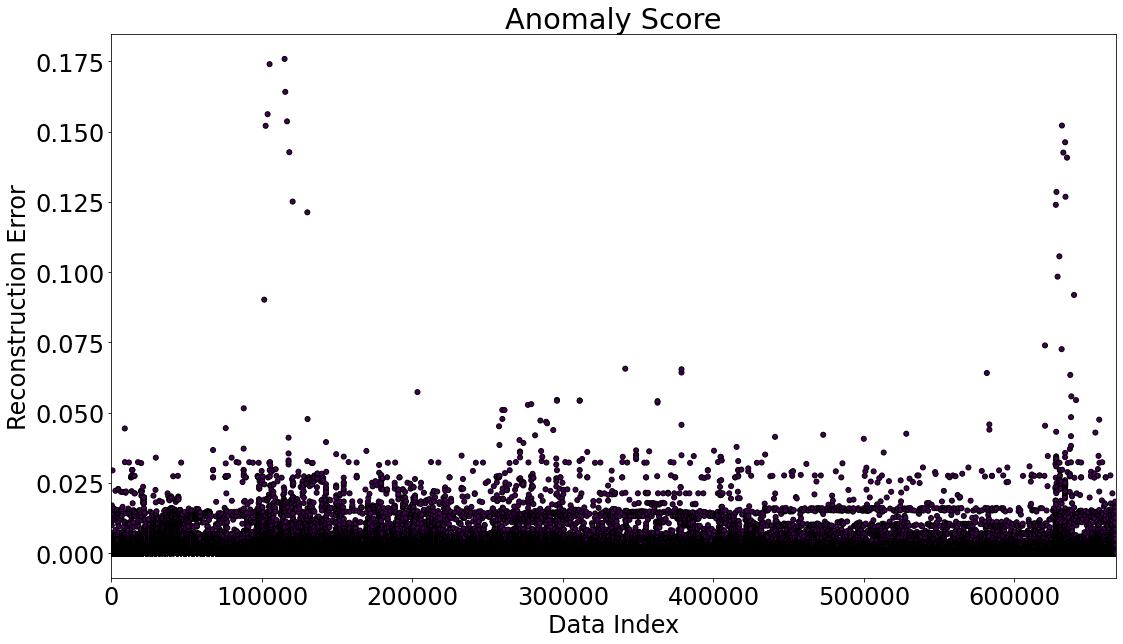

In [69]:
mpl.rcParams['font.size'] = 24
plt.rcParams["figure.figsize"] = (18,10)
#plt.figure(figsize=(16,8))
plt.scatter(data_error2.index, data_error2['reconstruction_error'], c=data_error2['Label'], edgecolor='black', s=25)
plt.xlabel('Data Index', fontsize = 24)
plt.ylabel('Reconstruction Error', fontsize = 24)
plt.xlim((-10,667378))
plt.title("Anomaly Score")
plt.show()

In [133]:
#####################Model Interpretability############################
####for test attack data

data_error1.sort_values(ascending=False, by = 'reconstruction_error').head(10)

,reconstruction_error,Label
78590,0.251001,1.0
220977,0.236107,1.0
180345,0.213552,1.0
191224,0.212902,1.0
180786,0.212584,1.0
193500,0.192730,1.0
226047,0.192668,1.0
214718,0.192153,1.0
228040,0.190850,1.0
327645,0.190681,1.0


In [73]:

data_error1.describe()

,reconstruction_error,Label
count,379737.000000,379737.0
mean,0.023834,1.0
std,0.026807,0.0
min,0.000023,1.0
25%,0.000291,1.0
50%,0.009725,1.0
75%,0.042925,1.0
max,0.251001,1.0


In [75]:
anomalies = data_error1.index[data_error1.reconstruction_error > 0.1].tolist()

In [79]:
numerical_cols = ['F_1', 'F_2', 'F_3', 'F_4', 'F_5', 'F_6', 'F_7', 'F_8', 'F_9','F_10', 'F_11', 'F_12', 'F_13', 'F_14', 'F_15', 'F_16', 'F_17', 'F_18','F_19','F_20','F_21', 'F_22', 'F_23', 'F_24', 'F_25', 'F_26', 'F_27', 'F_28','F_29','F_30','F_31', 'F_32', 'F_33', 'F_34', 'F_35', 'F_36', 'F_37', 'F_38','F_39','F_40','F_41', 'F_42', 'F_43', 'F_44', 'F_45', 'F_46', 'F_47', 'F_48','F_49','F_50','F_51', 'F_52', 'F_53', 'F_54', 'F_55', 'F_56', 'F_57', 'F_58','F_59','F_60','F_61', 'F_62', 'F_63', 'F_64', 'F_65', 'F_66', 'F_67', 'F_68','F_69','F_70','F_71', 'F_72', 'F_73', 'F_74', 'F_75', 'F_76']

In [80]:
data_n = pd.DataFrame(x_attack_woLabel, index= y_attack_df.index, columns=numerical_cols)

In [81]:
data_n.head()

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,...,F_67,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76
0,0.010782,0.000009,0.000024,0.000020,0.000018,0.000806,0.000000,0.001868,0.001440,0.299027,...,0.000010,0.15873,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
1,0.036845,0.000014,0.000000,0.000019,0.000000,0.000242,0.004076,0.001293,0.000000,0.000000,...,0.000014,0.15873,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
2,0.009029,0.000009,0.000021,0.000020,0.000018,0.000806,0.000000,0.001868,0.001440,0.224270,...,0.000010,0.15873,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
3,0.666953,0.000032,0.000014,0.000043,0.000018,0.000806,0.000000,0.001508,0.000794,0.448541,...,0.000029,0.15873,0.000009,0.0,0.000009,0.000009,0.3275,0.588196,0.588333,0.067272
4,0.005355,0.000009,0.000021,0.000020,0.000018,0.000806,0.000000,0.001868,0.001440,0.299027,...,0.000010,0.15873,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000


In [82]:
def compute_error_per_dim(point):
    
    initial_pt = np.array(data_n.loc[point,:]).reshape(1,76)
    reconstrcuted_pt = model.predict(initial_pt)
    
    return abs(np.array(initial_pt  - reconstrcuted_pt)[0])

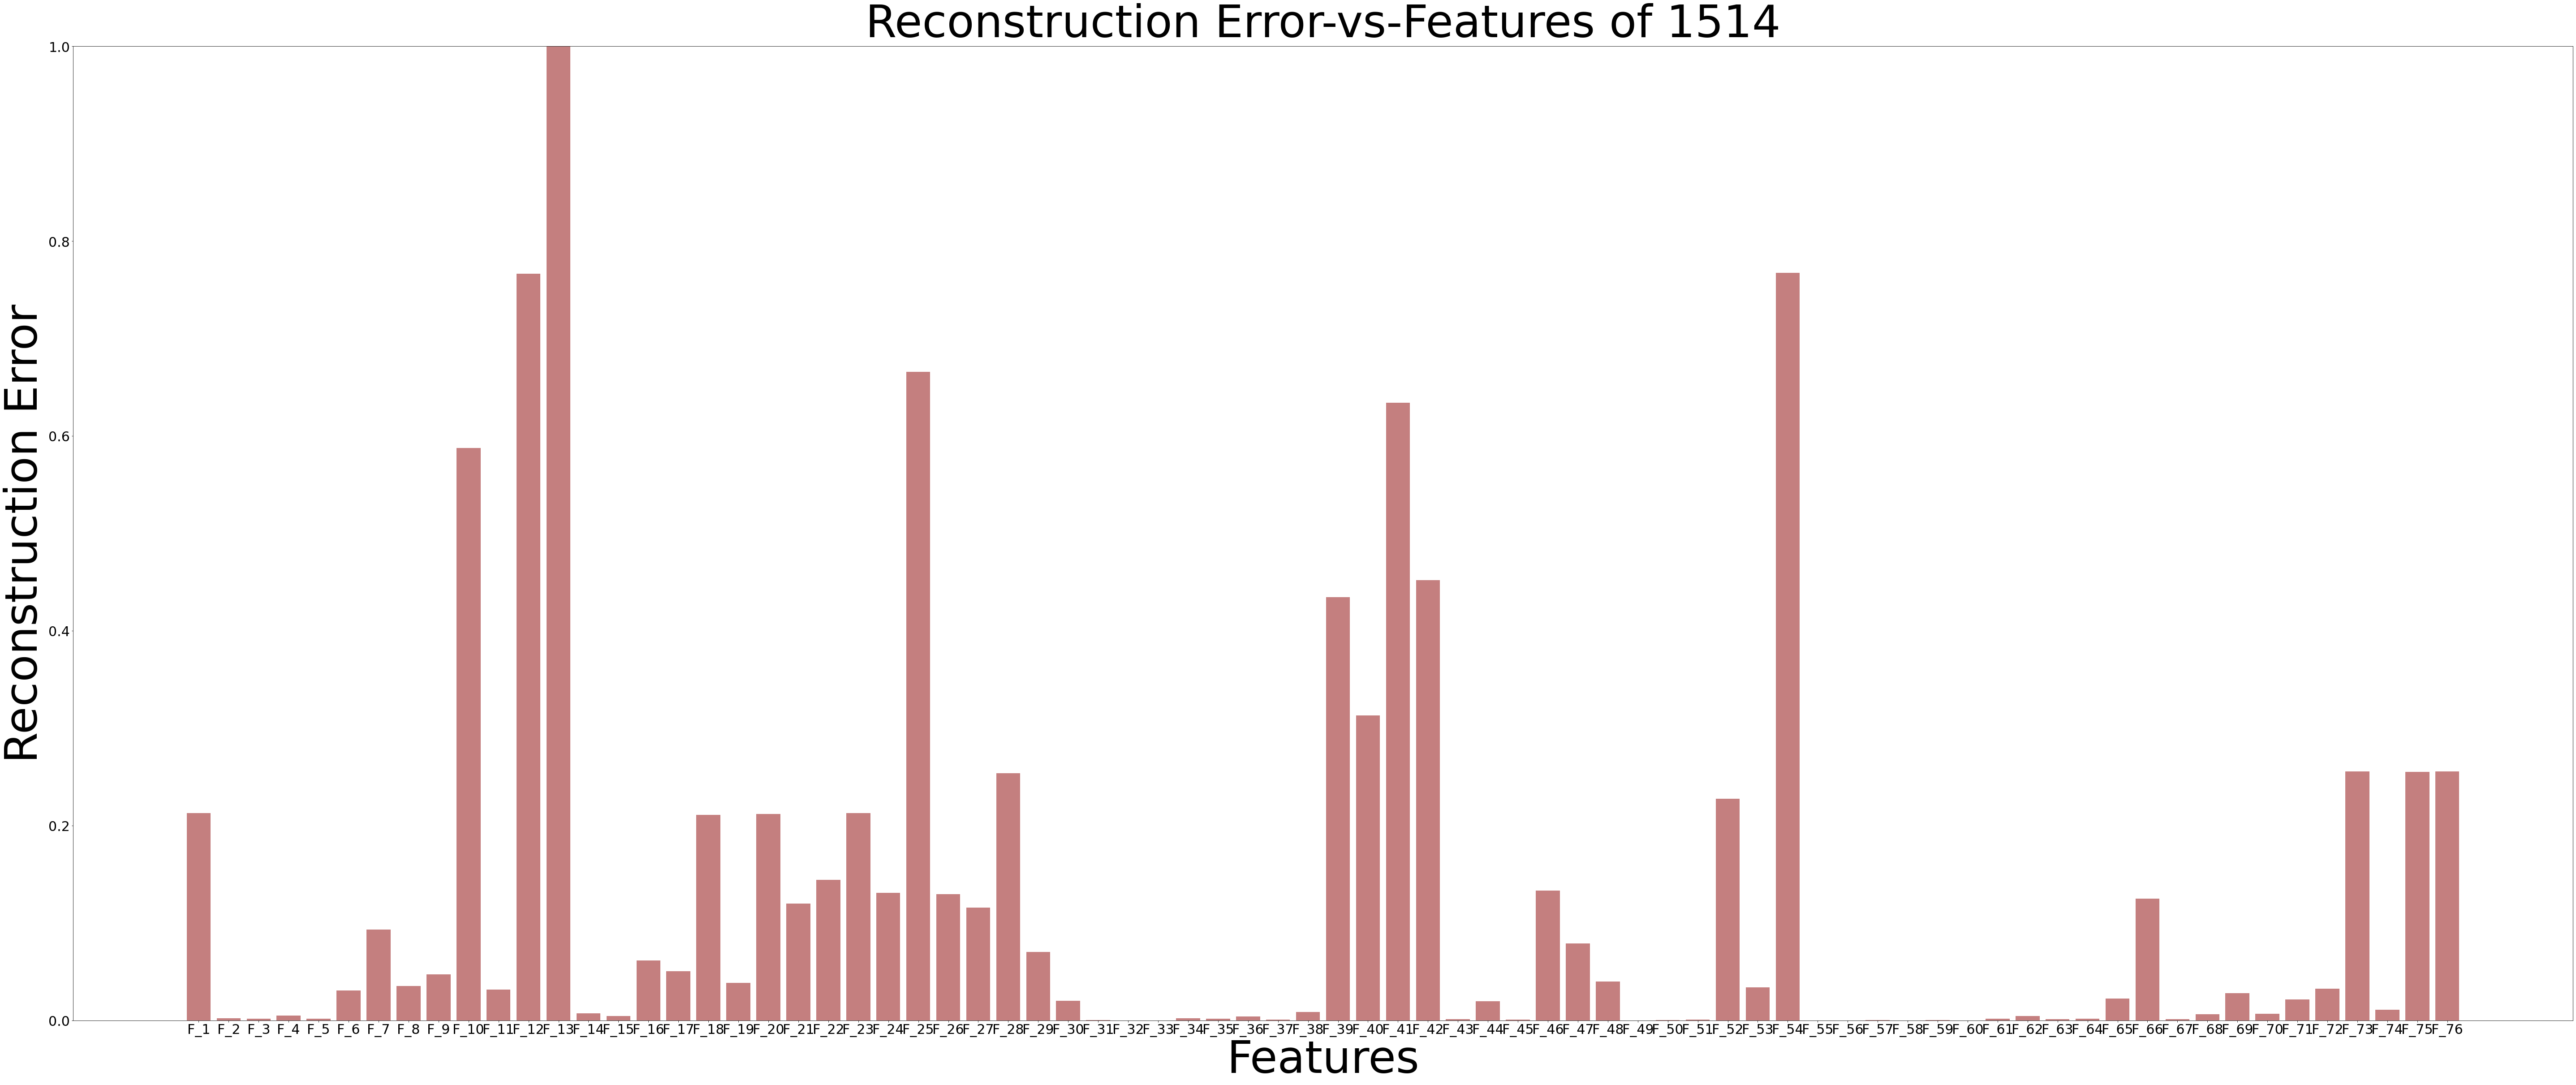

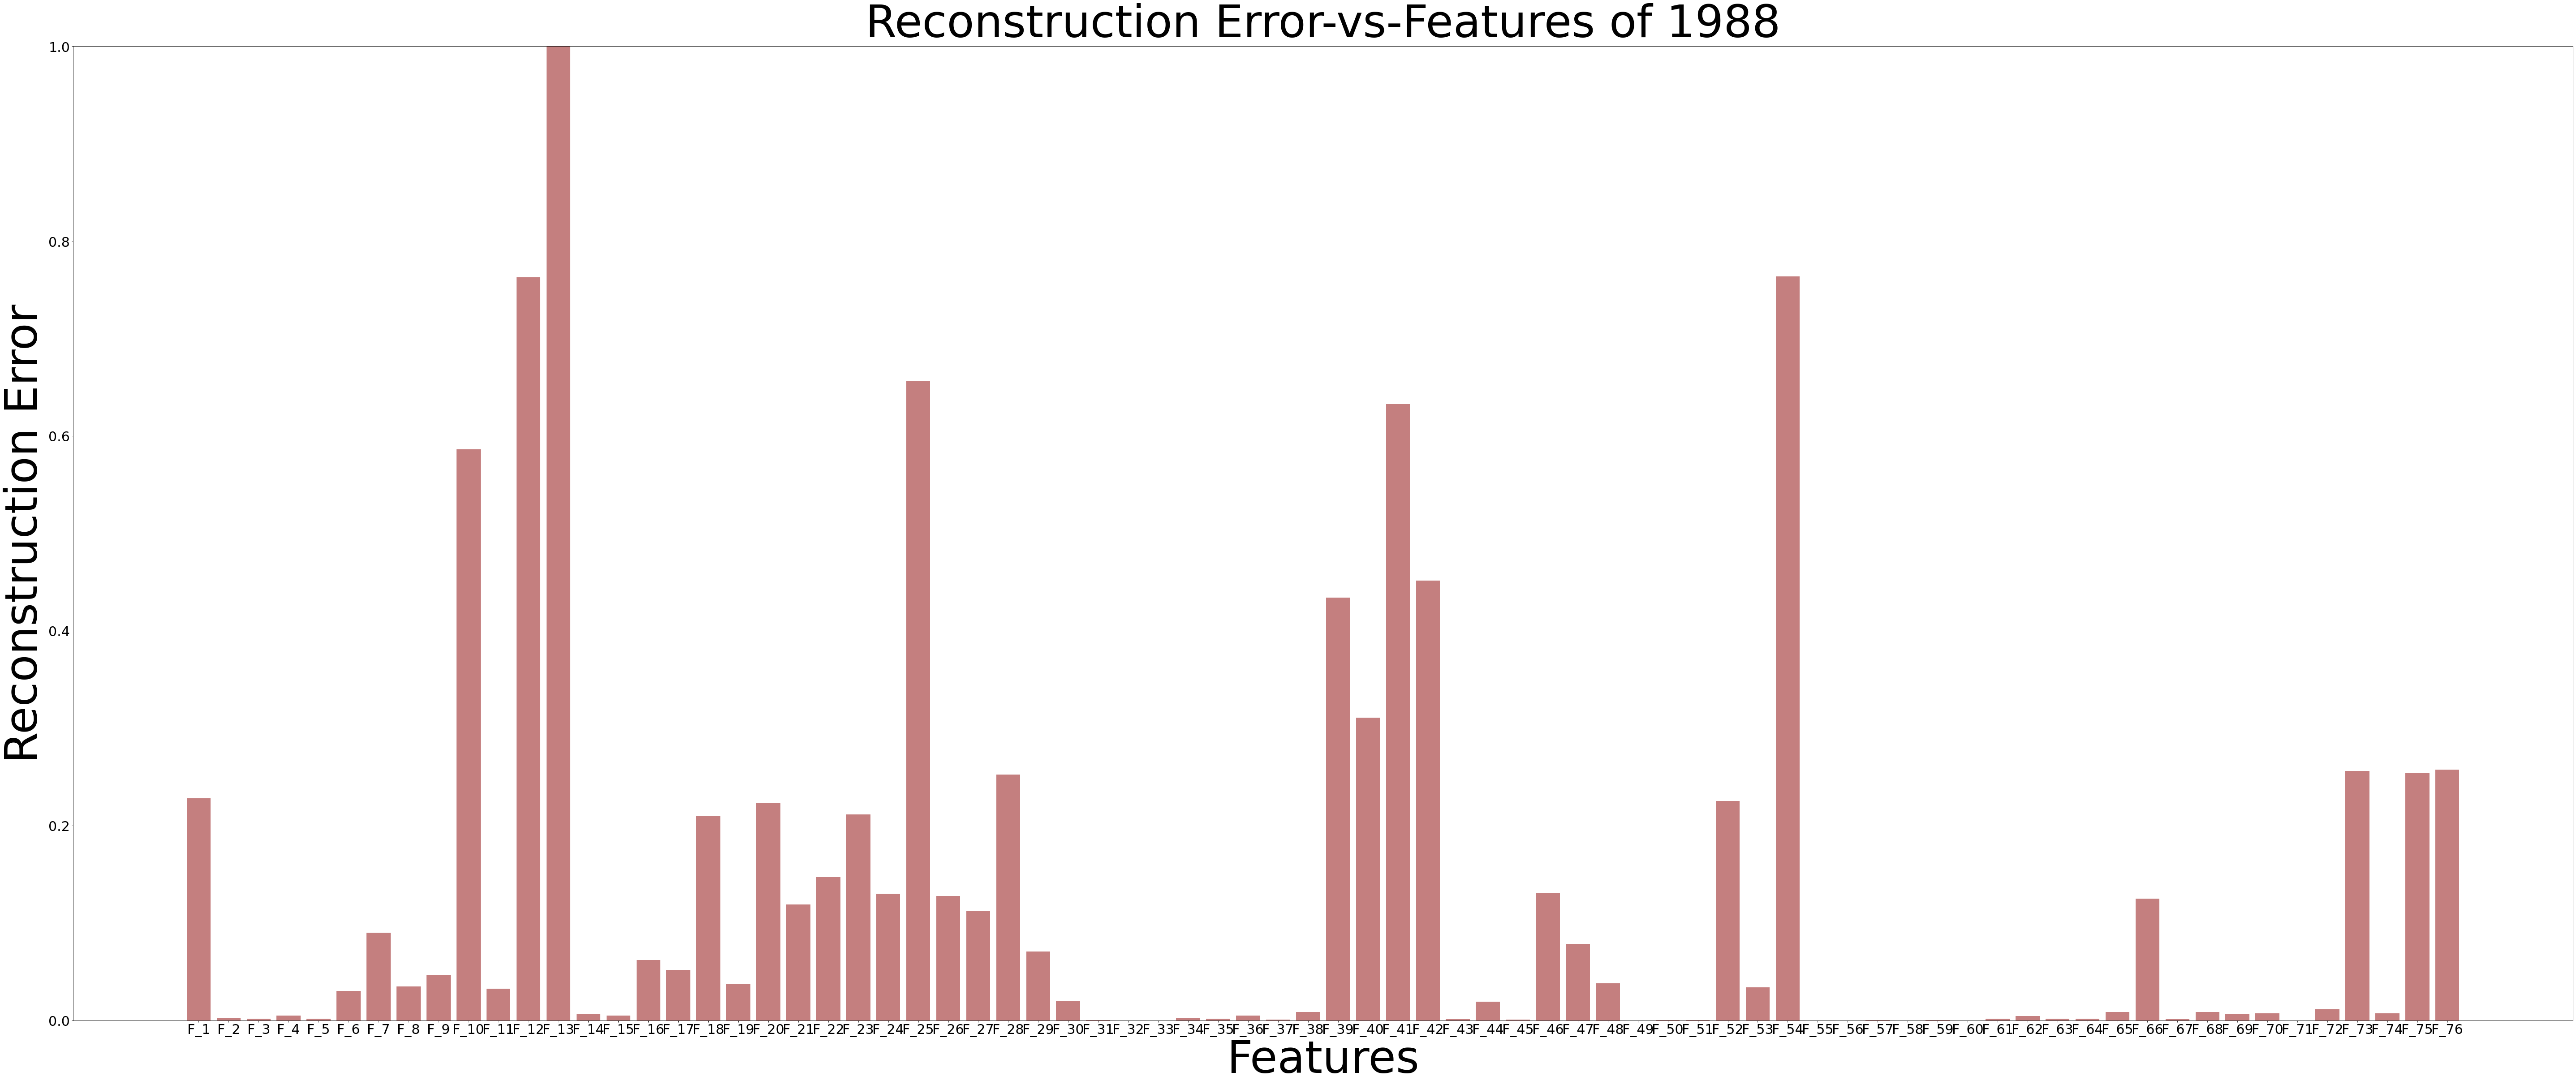

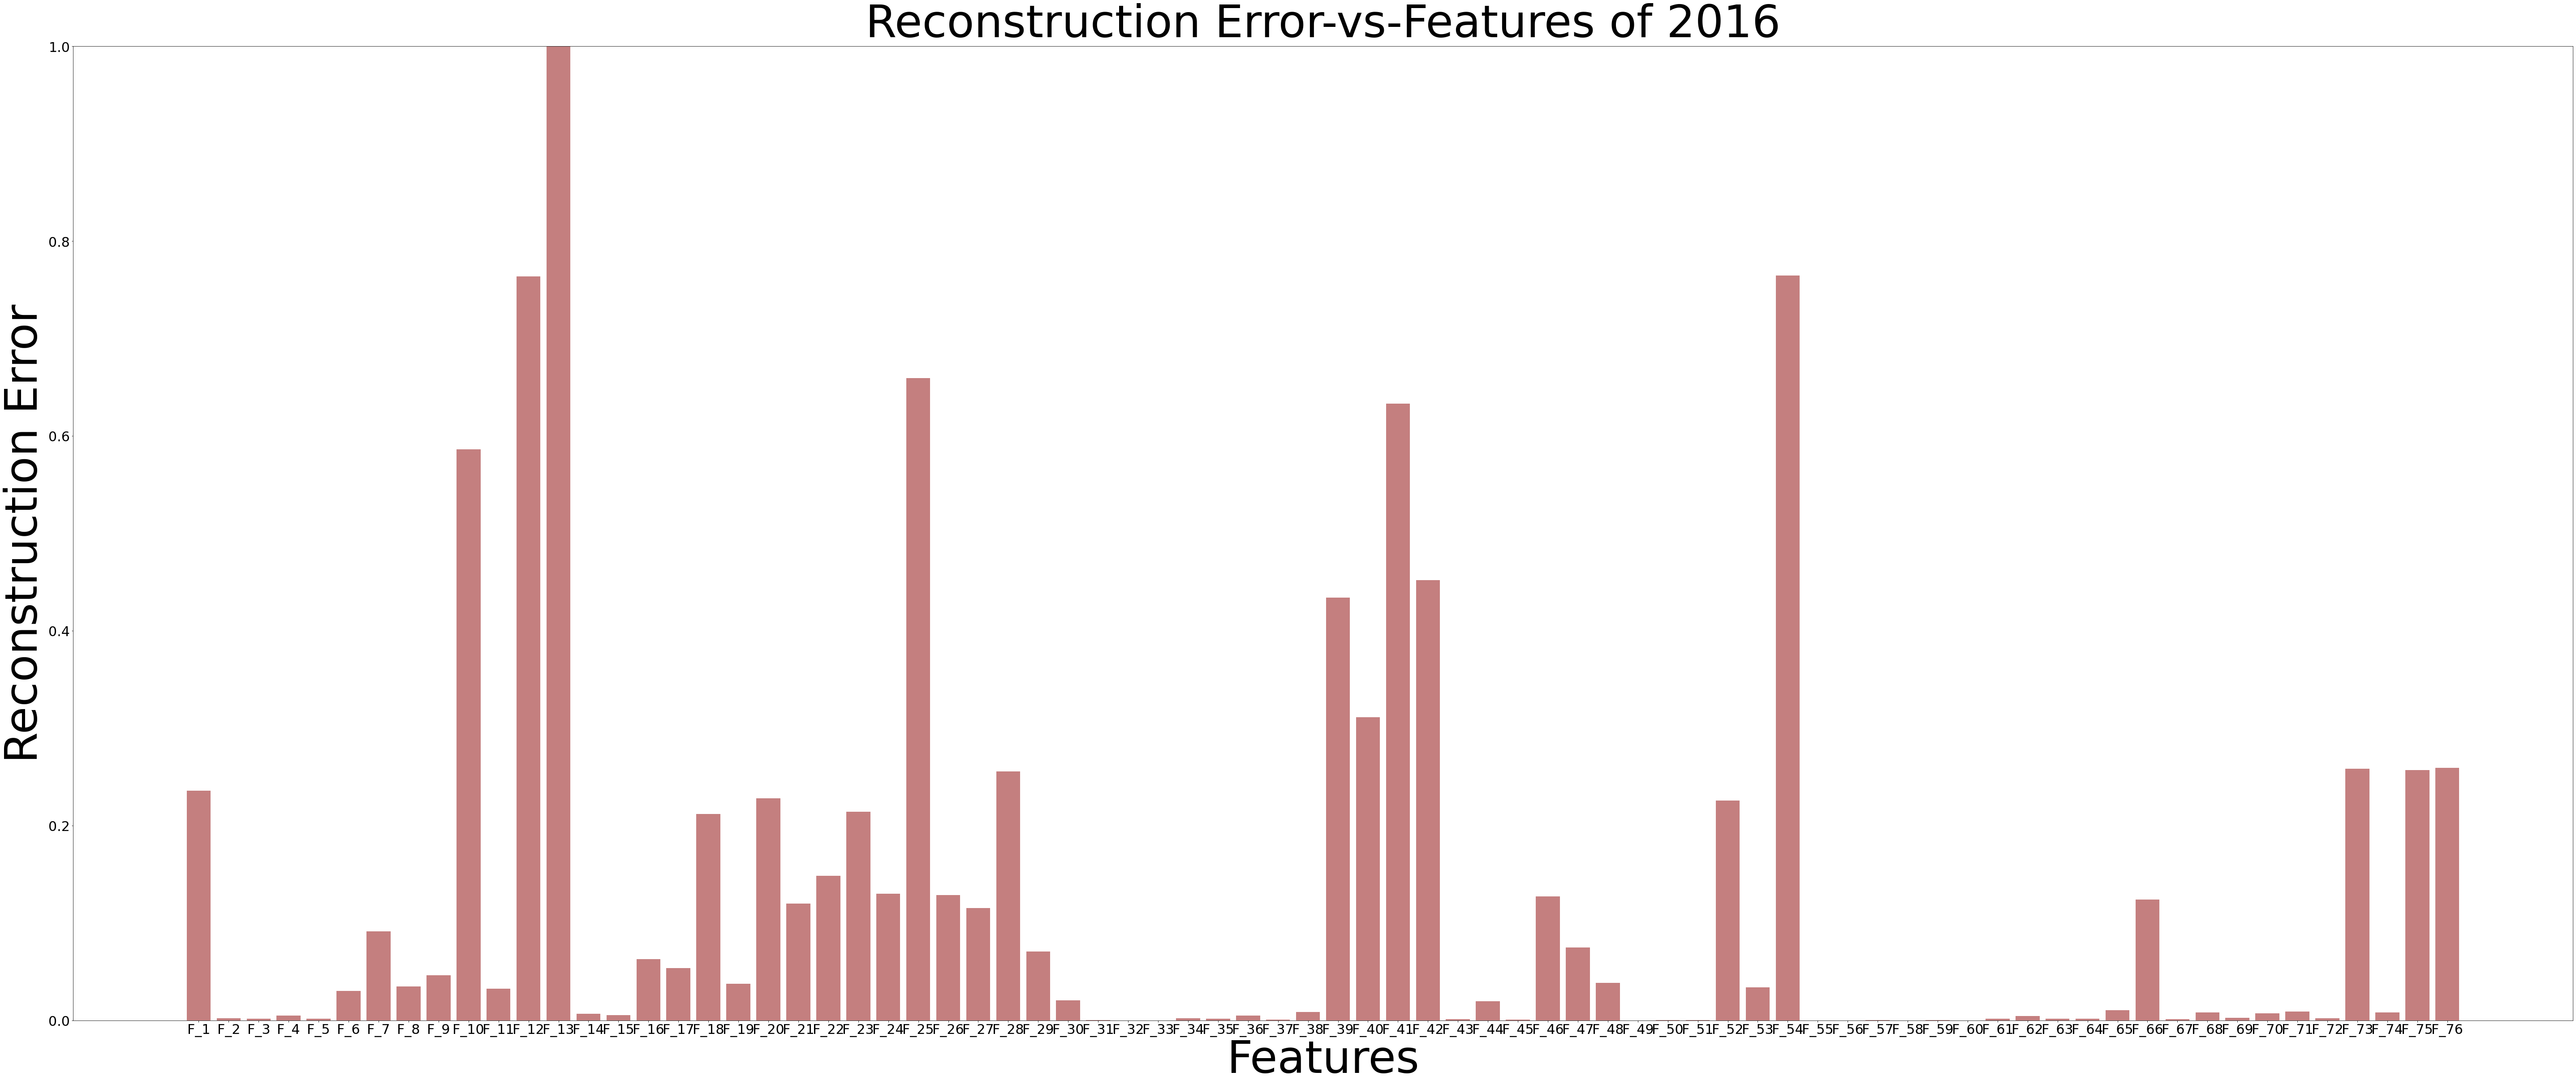

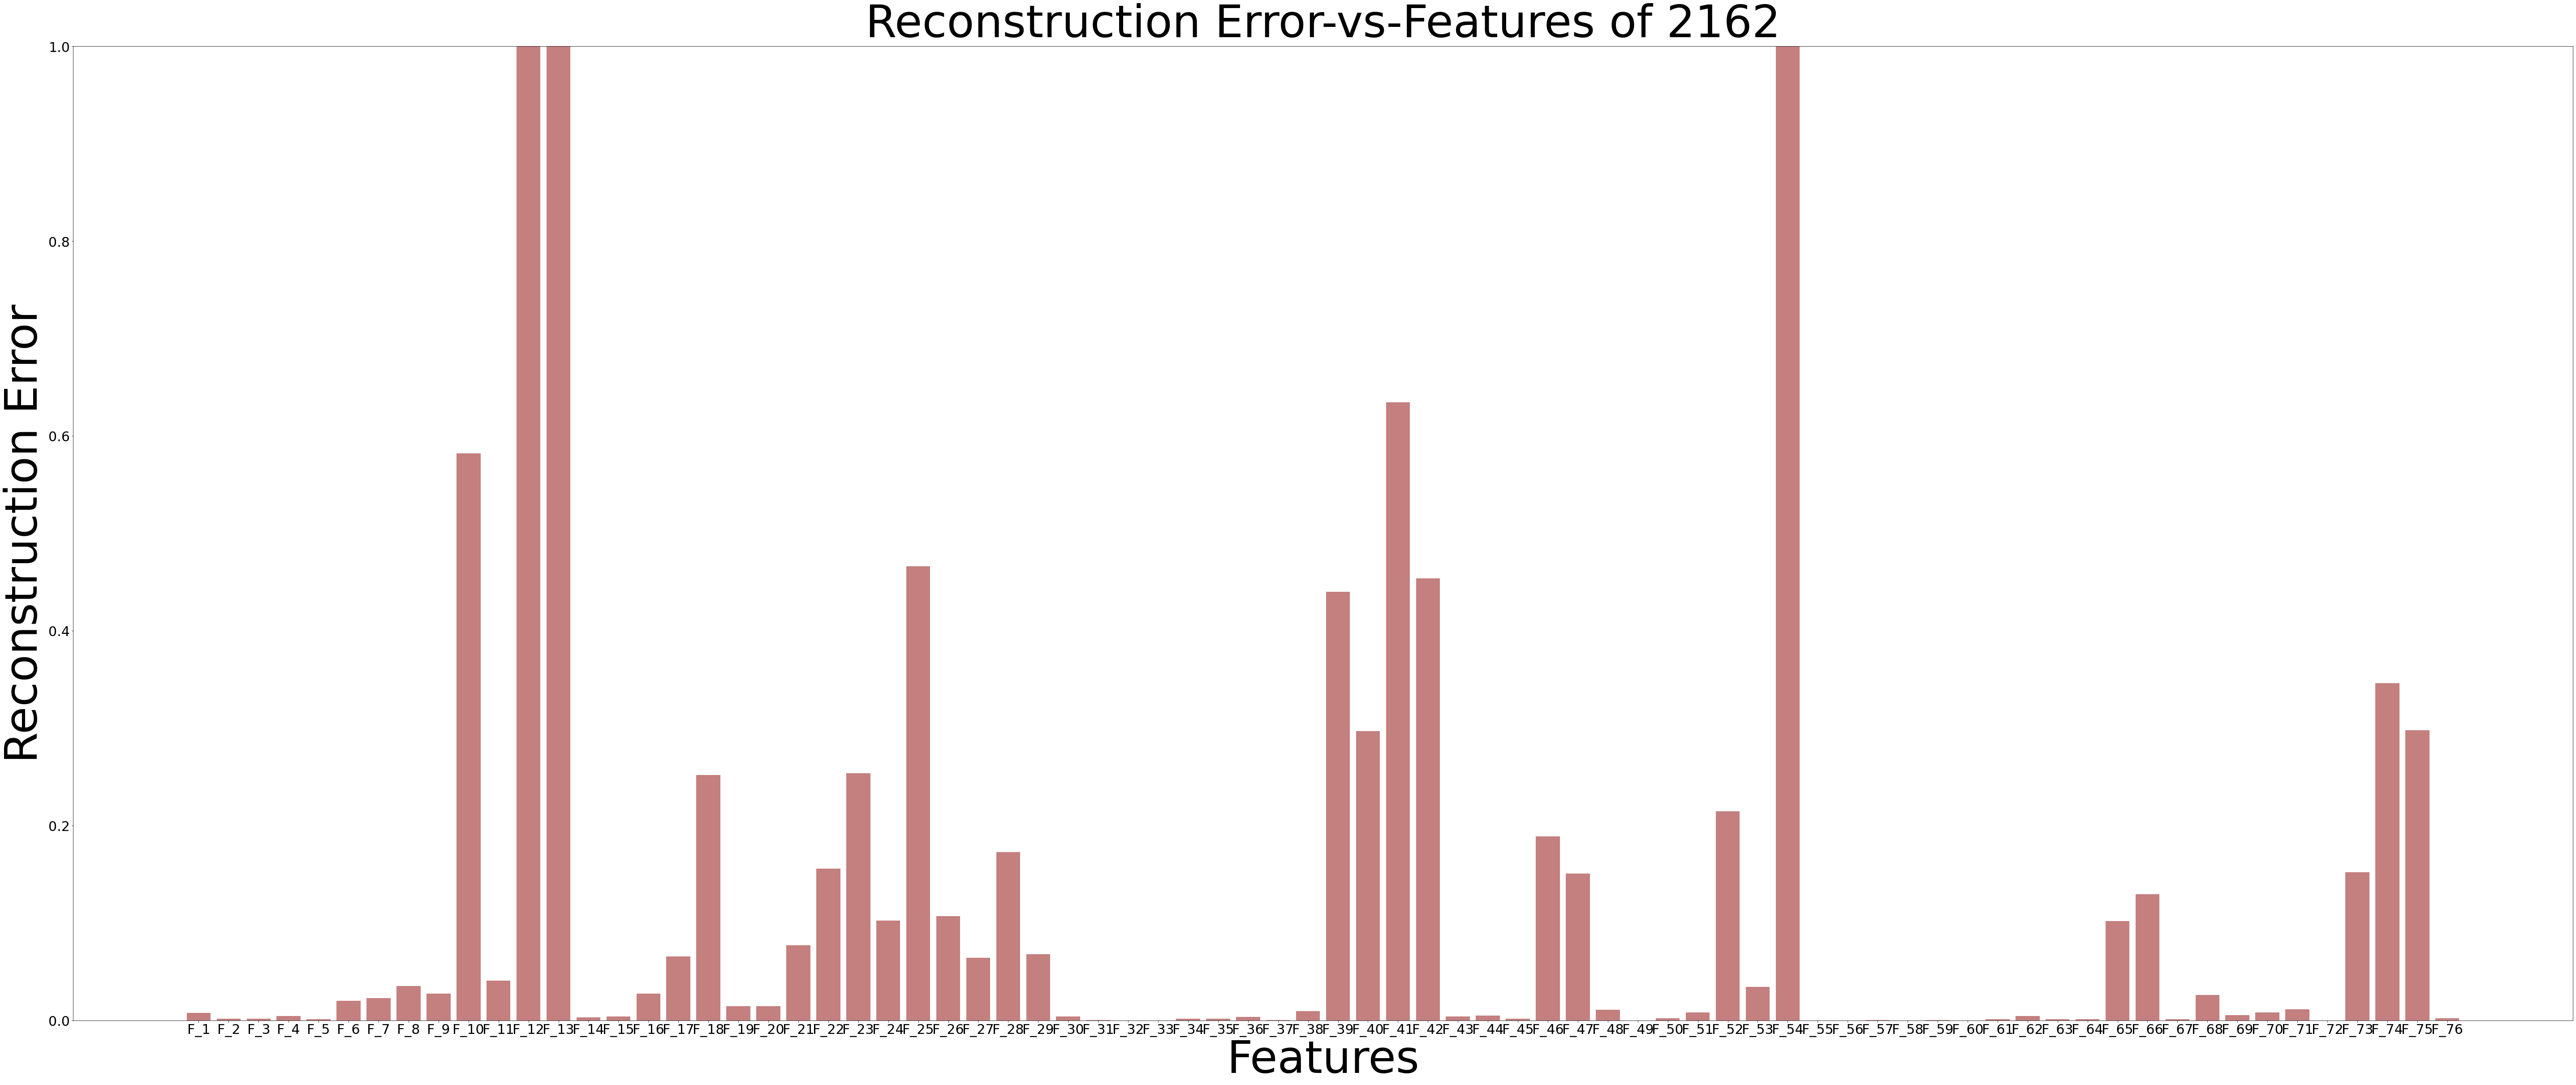

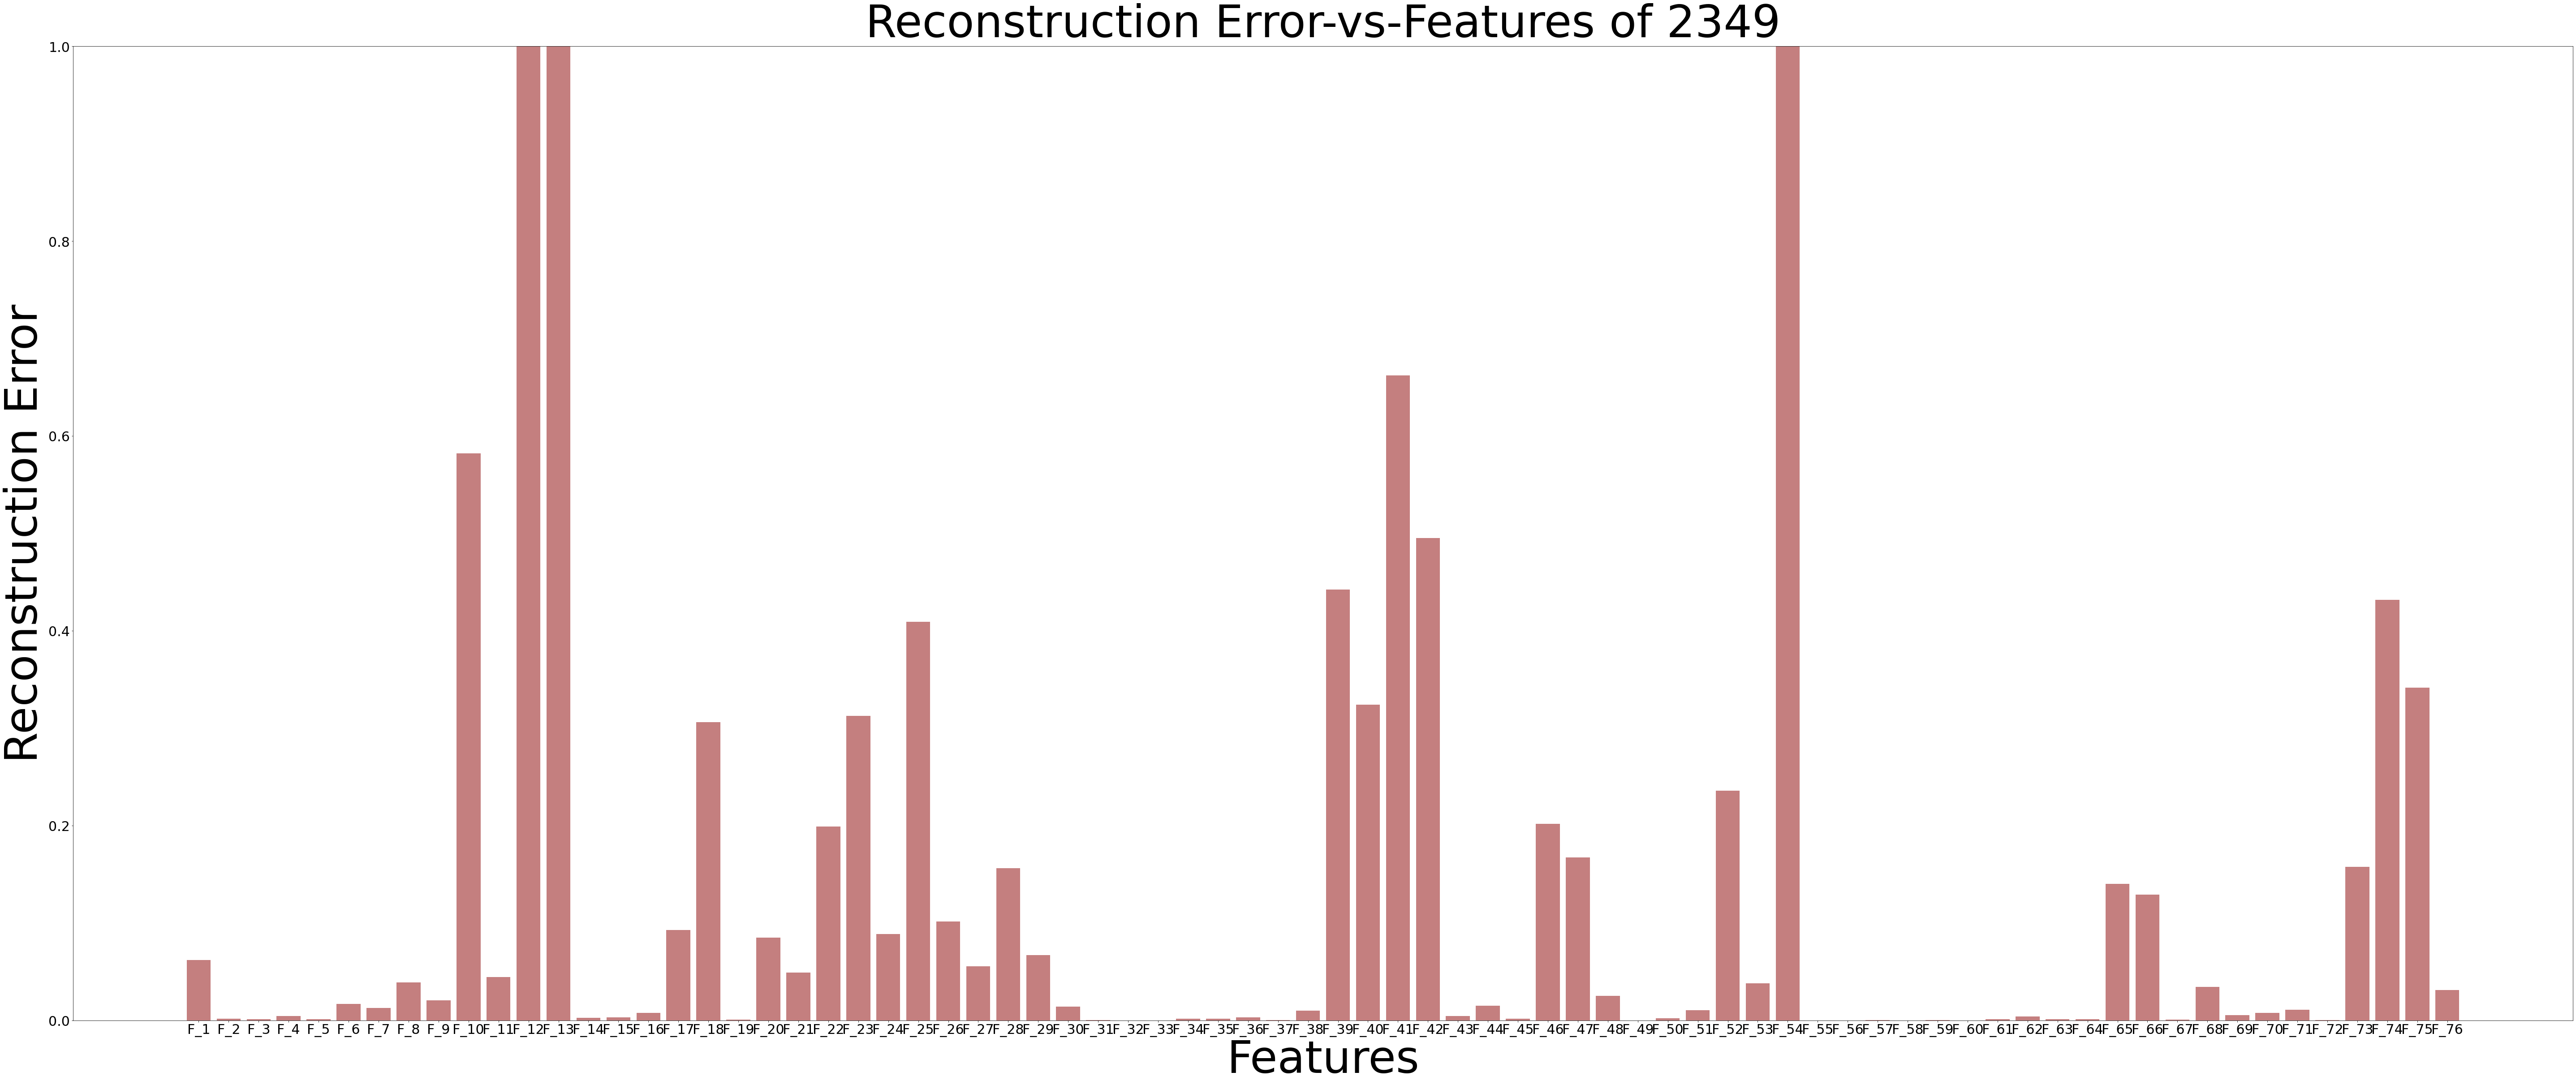

In [125]:
for i in anomalies[:5]:
    mpl.rcParams['font.size'] = 30
    plt.rcParams["figure.figsize"] = (100,40)
    #plt.figure(figsize=(80,10))
    objects = tuple(numerical_cols) 
    y_pos   = np.arange(len(objects))
    x       = np.arange(len(objects))
    y       = compute_error_per_dim(i).tolist()
    plt.ylim([0, 1.0])
    plt.bar(x, y, align='center', alpha=0.5,color='darkred')
    plt.xticks(y_pos, objects)
    plt.xlabel('Features',fontsize=100)
    plt.ylabel('Reconstruction Error', fontsize=100)
    plt.title('Reconstruction Error-vs-Features of {}'.format(i),fontsize=100)
    plt.show()

In [ ]:
#some features in the dataset contribute to higher reconstruction error (>0.55) for attack data. 
#These include feature 10, 12,13,25,41 and 54
#These features correspond to features namely, Bwd Packet Length Mean, Flow Bytes/s, Flow Packets/s, Bwd IAT Std, FIN Flag Count and Fwd Avg Packets/Bulk.

In [ ]:
#There is a patten for F_12,F_13,F_54 in contributing mainly to the reconstruction error! 
#These three features have highest values
#other features are F_10,F_25,F_39,F_41,F_42,F_74 AND F_75

In [105]:
# iterating the columns in the dataset with their indices
for idx ,col in enumerate(data.columns): 
    print(str(idx) + " " + str(col))

0  Flow Duration
1  Total Fwd Packets
2  Total Backward Packets
3 Total Length of Fwd Packets
4  Total Length of Bwd Packets
5  Fwd Packet Length Max
6  Fwd Packet Length Min
7  Fwd Packet Length Mean
8  Fwd Packet Length Std
9 Bwd Packet Length Max
10  Bwd Packet Length Min
11  Bwd Packet Length Mean
12  Bwd Packet Length Std
13 Flow Bytes/s
14  Flow Packets/s
15  Flow IAT Mean
16  Flow IAT Std
17  Flow IAT Max
18  Flow IAT Min
19 Fwd IAT Total
20  Fwd IAT Mean
21  Fwd IAT Std
22  Fwd IAT Max
23  Fwd IAT Min
24 Bwd IAT Total
25  Bwd IAT Mean
26  Bwd IAT Std
27  Bwd IAT Max
28  Bwd IAT Min
29 Fwd PSH Flags
30  Bwd PSH Flags
31  Fwd URG Flags
32  Bwd URG Flags
33 Fwd Header Length
34  Bwd Header Length
35 Fwd Packets/s
36  Bwd Packets/s
37  Min Packet Length
38  Max Packet Length
39  Packet Length Mean
40  Packet Length Std
41  Packet Length Variance
42 FIN Flag Count
43  SYN Flag Count
44  RST Flag Count
45  PSH Flag Count
46  ACK Flag Count
47  URG Flag Count
48  CWE Flag Count
49  EC

In [106]:
#############FOR OUT SAMPLE NORMAL DATA############
data_error.sort_values(ascending=False, by = 'reconstruction_error').head(10)

,reconstruction_error,Label
34952,0.152050,0.0
104308,0.146201,0.0
99926,0.090188,0.0
7631,0.072579,0.0
113355,0.065628,0.0
6647,0.065413,0.0
66495,0.063413,0.0
57854,0.055772,0.0
121281,0.054086,0.0
15694,0.053539,0.0


In [107]:
data_error.describe()

,reconstruction_error,Label
count,166845.000000,166845.0
mean,0.000382,0.0
std,0.001599,0.0
min,0.000017,0.0
25%,0.000035,0.0
50%,0.000076,0.0
75%,0.000189,0.0
max,0.152050,0.0


In [108]:
norm_anomalies = data_error.index[data_error.reconstruction_error > 0.1].tolist()

In [109]:
data_norm = pd.DataFrame(x_normal_test_woLabel, index= y_normal_test_df.index, columns=numerical_cols)

In [110]:
data_norm.head()

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,...,F_67,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76
0,2.526549e-02,0.000073,0.000055,0.000780,1.240247e-05,0.013014,0.000000,0.012739,0.013607,0.094828,...,0.000077,0.158730,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
1,4.166667e-07,0.000005,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.253968,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
2,7.000967e-03,0.000000,0.000021,0.000005,5.616212e-08,0.000242,0.004076,0.001293,0.000000,0.000307,...,0.000000,0.158730,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5.186398e-01,0.000078,0.000055,0.000823,8.719170e-06,0.014102,0.000000,0.012689,0.015616,0.074757,...,0.000082,0.158730,0.003447,0.011418,0.0182,0.000496,0.083335,0.000002,0.083338,0.083334
4,5.778084e-04,0.000032,0.000034,0.000300,2.363333e-05,0.015552,0.000000,0.010397,0.019152,0.148285,...,0.000005,0.253968,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000


In [111]:
def compute_error_per_dim1(point1):
    
    initial_pt1 = np.array(data_norm.loc[point1,:]).reshape(1,76)
    reconstrcuted_pt1 = model.predict(initial_pt1)
    
    return abs(np.array(initial_pt1  - reconstrcuted_pt1)[0])

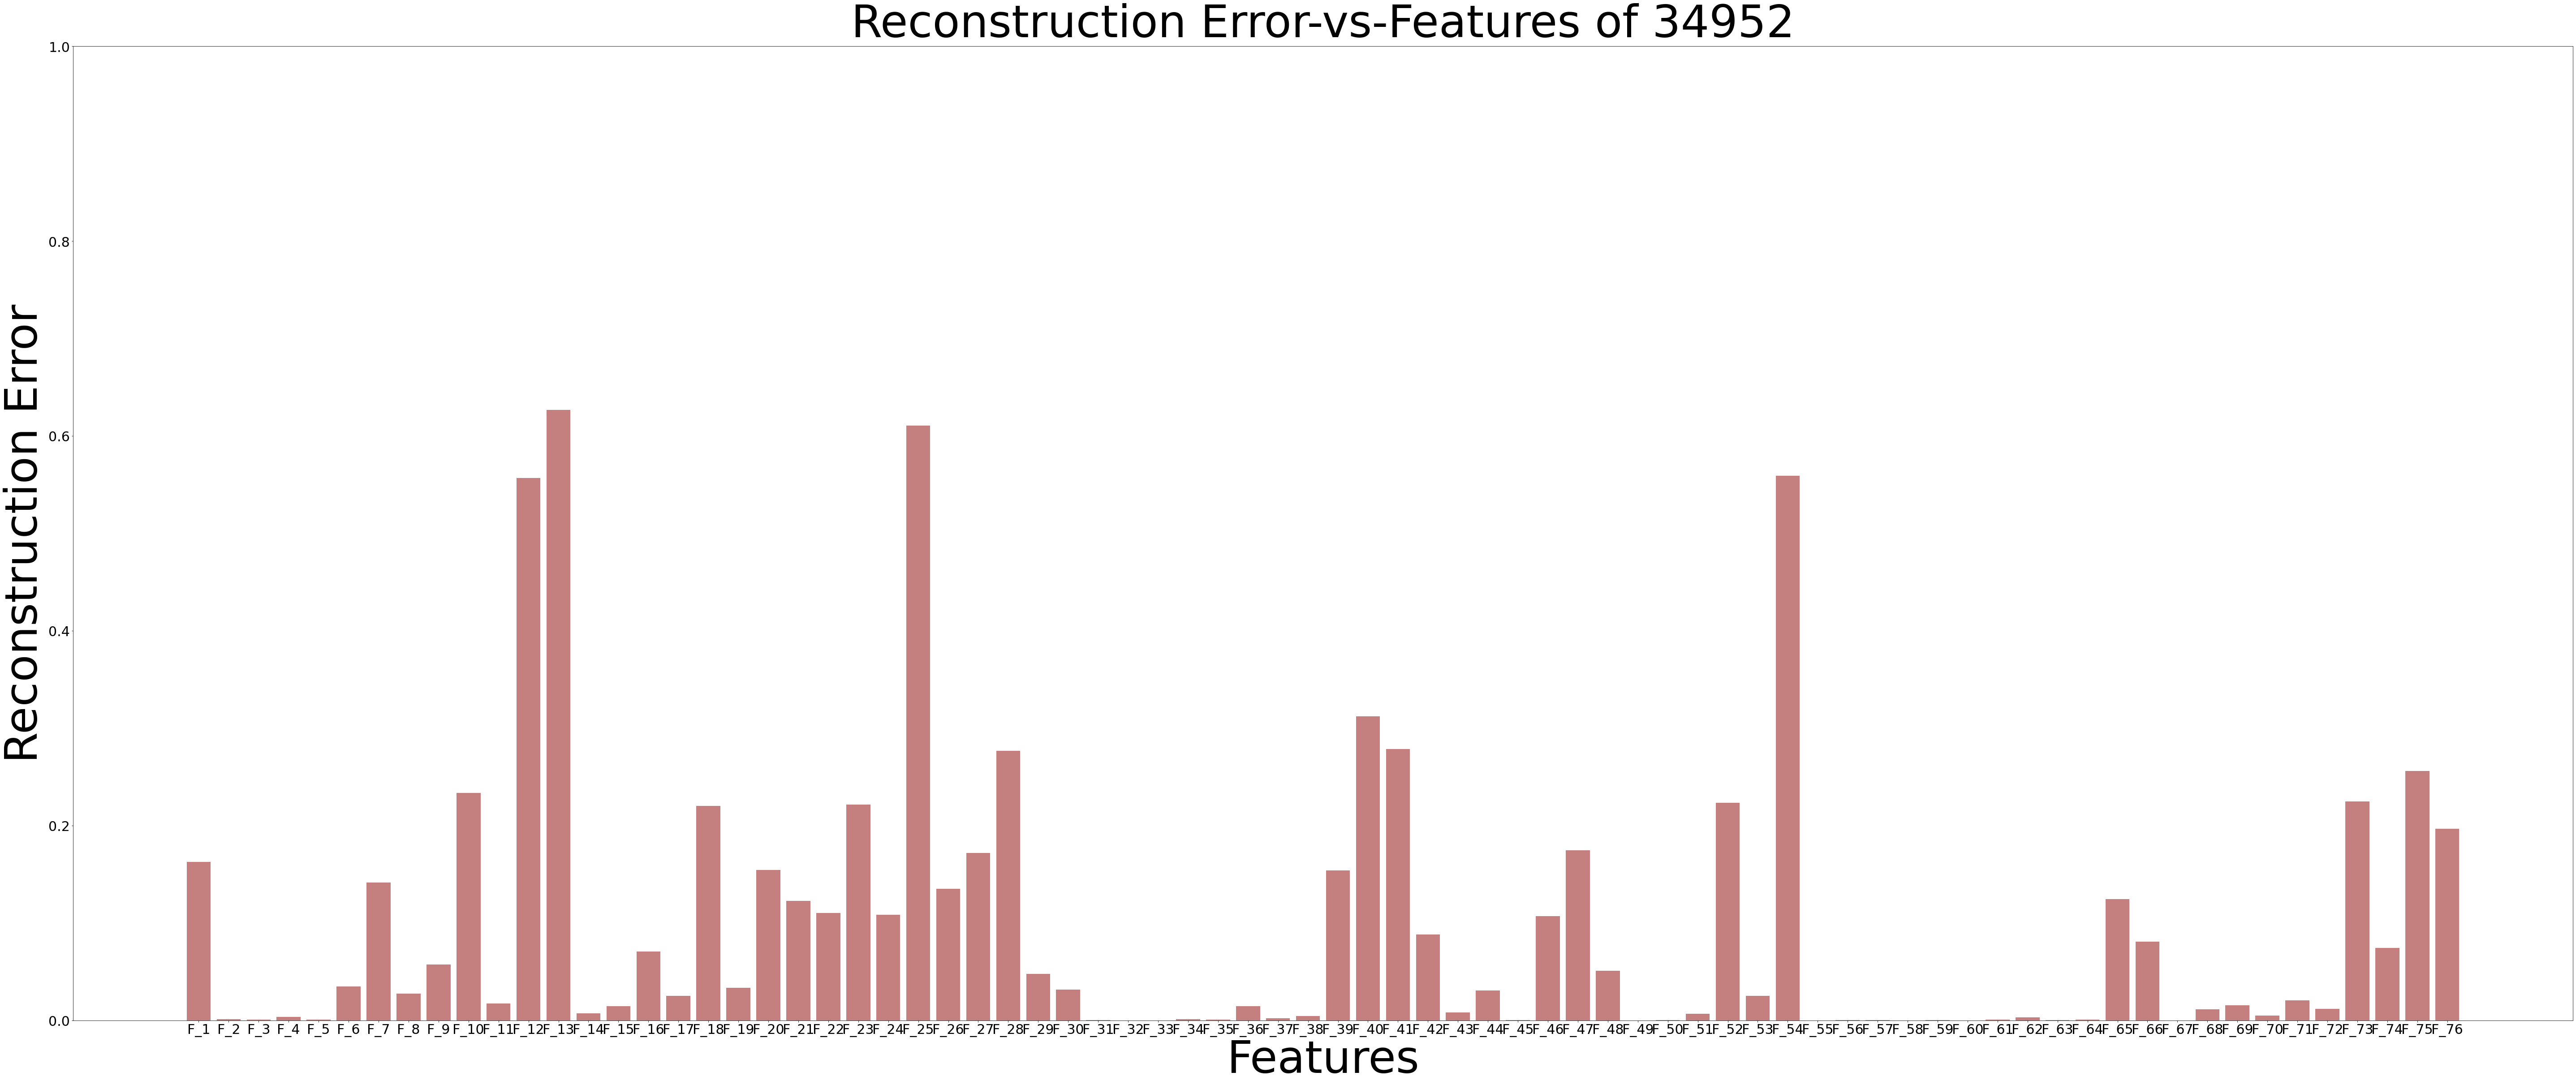

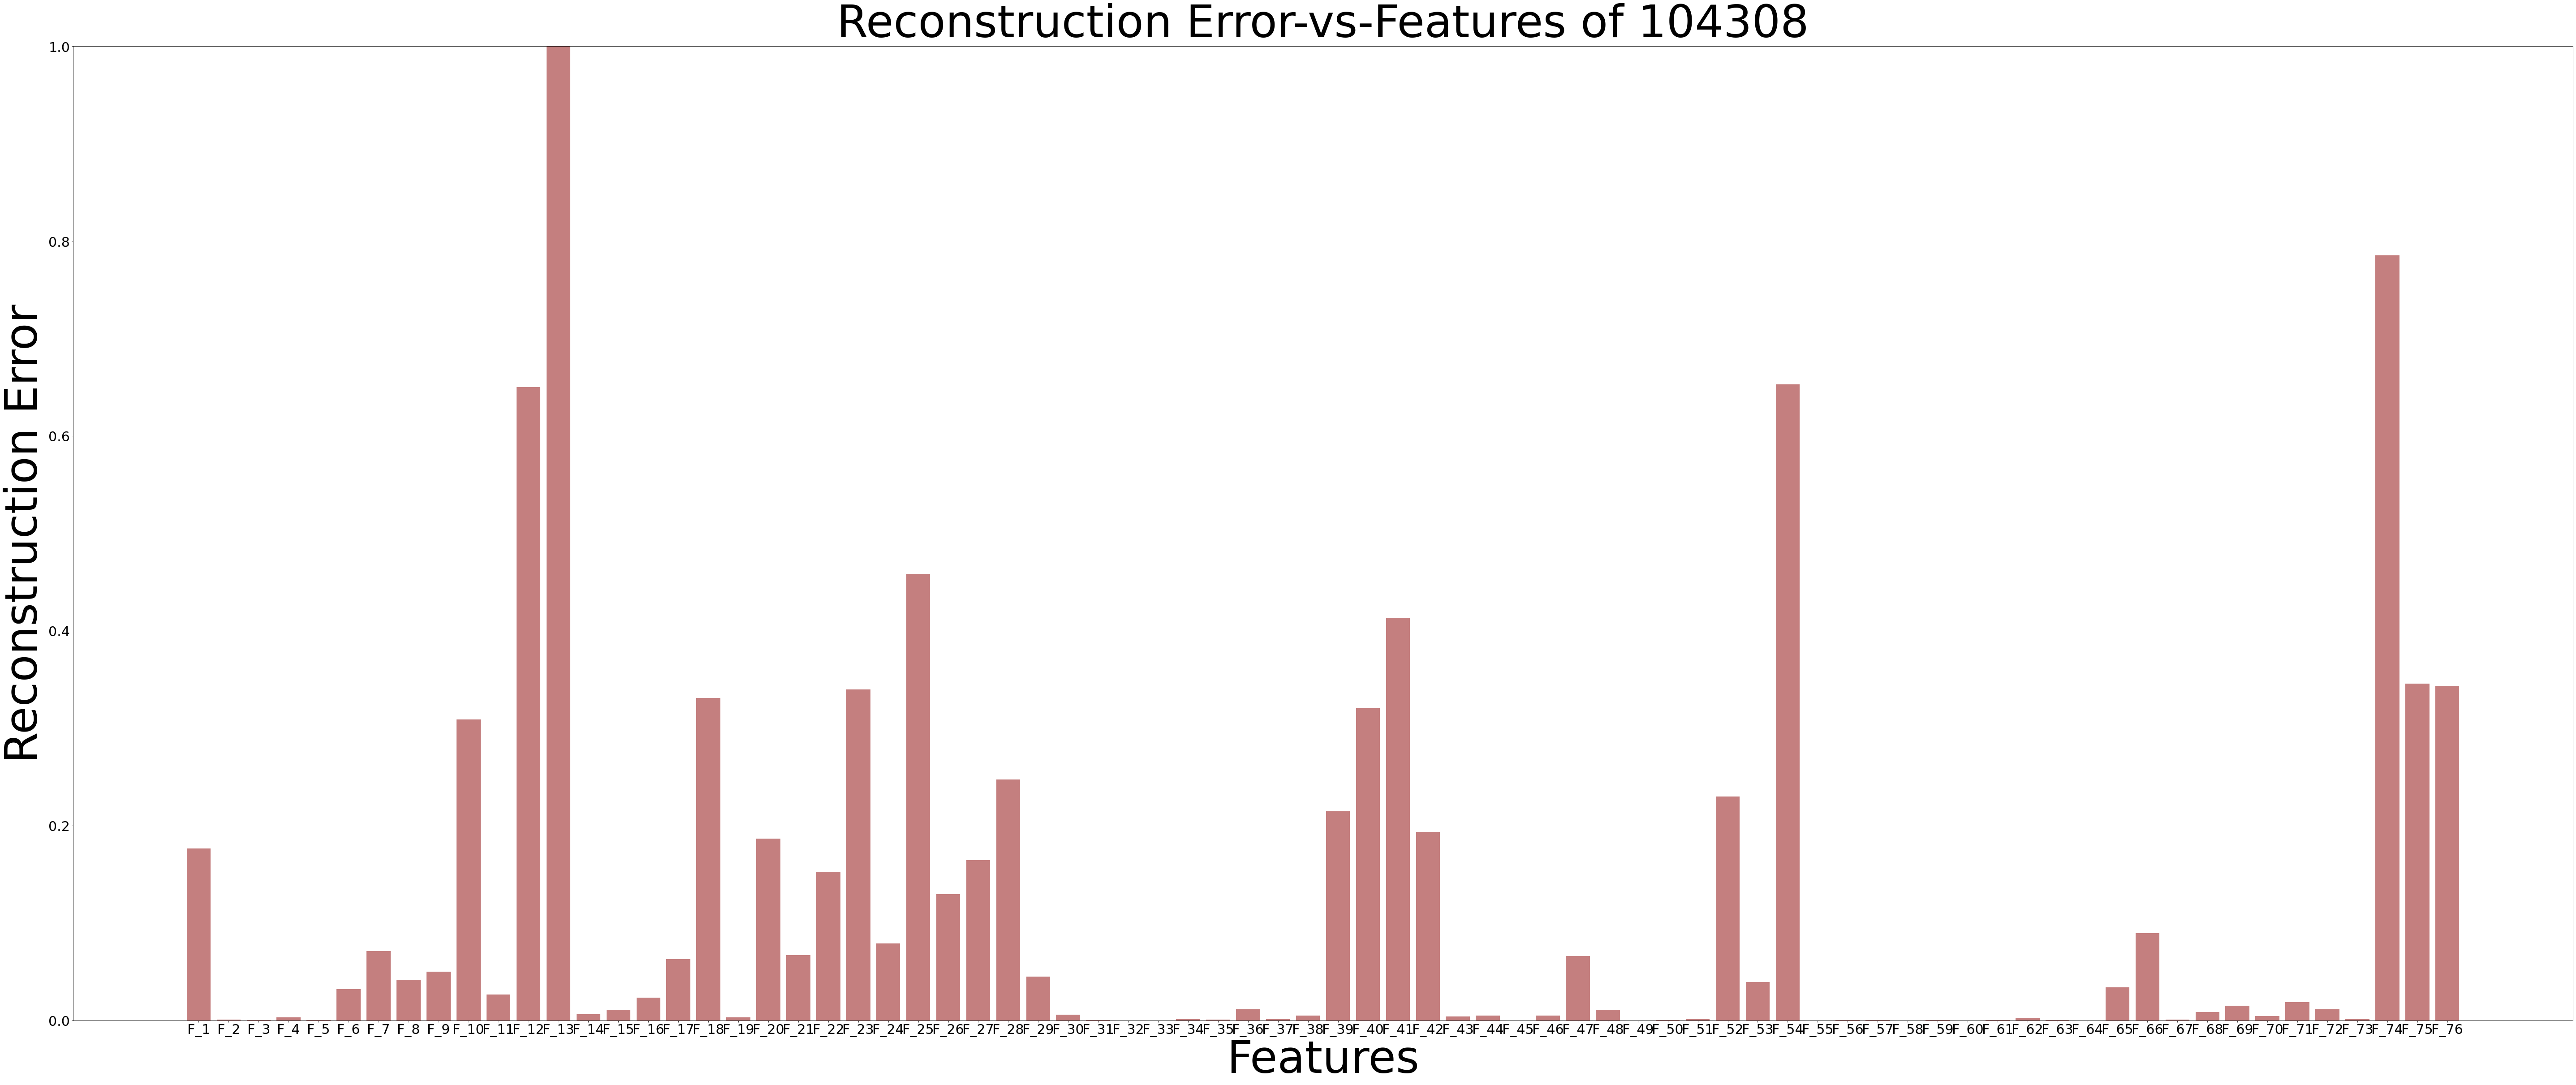

In [124]:
for i in norm_anomalies[:5]:
    mpl.rcParams['font.size'] = 30
    plt.rcParams["figure.figsize"] = (100,40)
    #plt.figure(figsize=(80,10))
    objects1 = tuple(numerical_cols) 
    y_pos1   = np.arange(len(objects1))
    x1       = np.arange(len(objects1))
    y1       = compute_error_per_dim(i).tolist()
    plt.ylim([0, 1.0])
    plt.bar(x1, y1, align='center', alpha=0.5,color='darkred')
    plt.xticks(y_pos1, objects1)
    plt.xlabel('Features',fontsize=100)
    plt.ylabel('Reconstruction Error', fontsize=100)
    plt.title('Reconstruction Error-vs-Features of {}'.format(i),fontsize=100)
    plt.show()

In [ ]:
###references
#https://github.com/abelusha/AutoEncoders-for-Anomaly-Detection/blob/master/AutoEncoders-for-Anomaly-Detection_Matplotlib.ipynb
#https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_14_03_anomaly.ipynb